# Env reward scaling - pettingzoo w/ infoduel-MADDPG

Ensures standard MADDPG works w/ my fold-change reward scaling scheme and dueling dual values.

Scales using MovingFoldChangeReward. 

### Background
In Dualer models I put reward and intrinsic rewards in competition. This means the two values must be matched up. Or put another way, that need to have common units. There are many ways to do that. Let's consider a biological motivated approach to reward normalization inspired by:

    - Adler, M., and Alon, U. (2018). Fold-change detection in biological
    systems. Current Opinion in Systems Biology 8, 81–89.
    - Karin, O., and Alon, U. (2021). The dopamine circuit as a reward-taxis navigation system. BioRxiv 439955, 30.

We'll try several `envs`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
from gym.spaces import Box
import numpy as np
import torch 
from tqdm import tqdm

from copy import deepcopy
from collections import defaultdict

import pettingzoo
from pettingzoo import mpe
import supersuit as ss
from supersuit import clip_actions_v0

from infoduel_maddpg.utils.buffer import ReplayBuffer
from infoduel_maddpg.core import MADDPG

from infoduel_maddpg.utils.academic_wrappers import StatePredictionWrapper
from infoduel_maddpg.utils.normalize_wrappers import ClipRewardWrapper
from infoduel_maddpg.utils.normalize_wrappers import MovingFoldChangeRewardWrapper

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline

# Init

In [4]:
env_name = "simple_v2"
# env_name = "simple_tag_v2"

In [27]:
seed = 50
eta = 1.0
n_episodes = 5000 # 25000
episode_length = 25
batch_size = 1024
steps_per_update = 100
init_noise_scale = 0.3
final_noise_scale = 0.0
n_exploration_eps = n_episodes
lr = 0.01
do_fold = True
do_clip = True

# Init Env

In [28]:
Env = getattr(mpe, env_name)
env = Env.parallel_env(continuous_actions=True)
env = clip_actions_v0(env)

academic = Env.parallel_env(continuous_actions=True)
academic = clip_actions_v0(academic)
academic = StatePredictionWrapper(
        academic,
        network_hidden=[64],
        lr=lr/10,
        device="cpu",
    )
    
# Fold-change?
if do_fold:
    env  = MovingFoldChangeRewardWrapper(
        env, 
        intial_reference_reward=-2, 
        bias_reward=0, 
    )
    academic = MovingFoldChangeRewardWrapper(
        academic, 
        intial_reference_reward=0.01, 
        bias_reward=0, 
    )
# Clip?
if do_clip:
    env = ClipRewardWrapper(env, min_reward=-100, max_reward=100)
    academic = ClipRewardWrapper(academic, min_reward=-100, max_reward=100)

# Run

In [29]:
print(f"----- Running: {env_name} ------")
print(f"device: cpu")
# print(f"log_dir: {log_dir}")

# Make access to 'space' info in format that is
# expected through the codebase
action_space = [env.action_space(a) for a in env.possible_agents]
observation_space = [env.observation_space(a) for a in env.possible_agents]

maddpg = MADDPG.init_from_env(
    env,
    agent_alg="MADDPG",
    adversary_alg="MADDPG",
    tau=0.01,
    lr=lr,
    hidden_dim=64,
)
replay_buffer = ReplayBuffer(
    n_episodes,
    maddpg.nagents,
    [obsp.shape[0] for obsp in observation_space],
    [acsp.shape[0] if isinstance(acsp, Box) else acsp.n for acsp in action_space],
)

intrinsic_maddpg = MADDPG.init_from_env(
    academic,
    agent_alg="MADDPG",
    adversary_alg="MADDPG",
    tau=0.01,
    lr=lr,
    hidden_dim=64,
)
intrinsic_replay_buffer = ReplayBuffer(
    n_episodes,
    maddpg.nagents,
    [obsp.shape[0] for obsp in observation_space],
    [acsp.shape[0] if isinstance(acsp, Box) else acsp.n for acsp in action_space],
)

# ---
env.seed(seed)
academic.seed(seed)

episode_rewards = []
total_rewards = []
total_intrinsics = []
episode_intrinsics = []
for n in tqdm(range(n_episodes)):
    # print(f"Episodes {n + 1}-{n + 2} of {n_episodes}")

    # --- Rollout prep
    obs = env.reset()
    _ = academic.reset()

    maddpg.prep_rollouts(device="cpu")
    intrinsic_maddpg.prep_rollouts(device="cpu")
    
    # --- Do the INFODUEL!
    # Set the policy on a per episode basis for a little more
    # stability then on every step. This is violation of out
    # formality, but only a little one. :)
    if n == 0:
        last_rewards = [0] * len(env.possible_agents)
        last_intrinsics = [eta + 0.0001,] * len(academic.possible_agents) # favor first
    else:
        last_rewards = replay_buffer.get_max_rewards(episode_length)
        last_intrinsics = intrinsic_replay_buffer.get_max_rewards(episode_length)

    meta_maddpg = {}
    for i, a in enumerate(env.possible_agents):        
        # Use best value to set the policy, agent by agent.
        # They can either persue rewards or info value,
        # but never both at the same time...
        #
        # This is why
        # we call this library 'INFODUEL'
        meta = None
        if last_rewards[i] >= (last_intrinsics[i] - eta):
            meta_maddpg[a] = maddpg.agents[i]
            meta = 0  # default reward greed
        else:
            meta_maddpg[a] = intrinsic_maddpg.agents[i]
            meta = 1

    # --- do Rollout
    for t in range(episode_length):
        # If there are no agents the env
        # should be restarted.
        if len(env.agents) == 0:
            obs = env.reset()
            _ = academic.reset()

        # rearrange observations for maddpg
        torch_obs = [
            torch.tensor(obs[a], requires_grad=False).unsqueeze(0)
            for a in env.possible_agents
        ]

        # Use meta_maddpg to step each agent
        # to get their actions
        agent_actions = {}
        for i, a in enumerate(env.possible_agents):
            act = meta_maddpg[a].step(torch_obs[i], explore=False)
            act = act.data.numpy().flatten()
            agent_actions[a] = act

        # ...and apply these actions to the env
        next_obs, rewards, dones, infos = env.step(agent_actions)
        next_obs_in, intrinsics, dones_in, infos_in = academic.step(agent_actions)
             
        episode_rewards.append(rewards)
        episode_intrinsics.append(intrinsics)
        replay_buffer.push(
            [obs[a] for a in env.possible_agents],
            [agent_actions[a] for a in env.possible_agents],
            [rewards[a] for a in env.possible_agents],
            [next_obs[a] for a in env.possible_agents],
            [dones[a] for a in env.possible_agents],
        )
        intrinsic_replay_buffer.push(
            [obs[a] for a in academic.possible_agents],
            [agent_actions[a] for a in academic.possible_agents],
            [intrinsics[a] for a in academic.possible_agents],
            [next_obs_in[a] for a in academic.possible_agents],
            [dones_in[a] for a in academic.possible_agents],
        )

        # sanity
        for a in next_obs.keys():
            assert np.allclose(next_obs[a], next_obs_in[a]), f"At step {n}, agent {a} next_obs disagreed between env and academic."

        # setup for next step
        obs = next_obs
        t += 1

        # --- Train (ugly code)?
        if (
            len(replay_buffer) >= batch_size
            and (t % steps_per_update) == 1
        ):
            # reward
            maddpg.prep_training(device="cpu")
            for a_i, a_n in enumerate(env.possible_agents):
                sample = replay_buffer.sample(batch_size, "cpu")
                maddpg.update(sample, a_i, a_n, logger=None)
            maddpg.update_all_targets()
            maddpg.prep_rollouts(device="cpu")

            # info val
            intrinsic_maddpg.prep_training(device="cpu")
            for a_i, a_n in enumerate(academic.possible_agents):
                sample = intrinsic_replay_buffer.sample(batch_size, "cpu")
                intrinsic_maddpg.update(sample, a_i, a_n, logger=None)
            intrinsic_maddpg.update_all_targets()
            intrinsic_maddpg.prep_rollouts(device="cpu")
    
    # -- Log (ep)
    total_rewards.append(deepcopy(last_rewards))
    total_intrinsics.append(deepcopy(last_intrinsics))

----- Running: simple_v2 ------
device: cpu


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/qualia/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  1%|          | 41/5000 [00:05<10:48,  7.65it/s]/Users/qualia/Code/infoduel_maddpg/infoduel_maddpg/core.py:156: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(curr_agent.critic.parameters(), 0.5)
/Users/qualia/Code/infoduel_maddpg/infoduel_maddpg/core.py:189: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(curr_agent.policy.parameters(), 0.5)
100%|██████████| 5000/5000 [13:00<00:00,  6.40it/s]


## Visualize

[0.         0.75986134 0.97298017 ... 0.64748128 0.6519418  0.02169051]


Text(0.5, 1.0, 'Late (121000, 125000)')

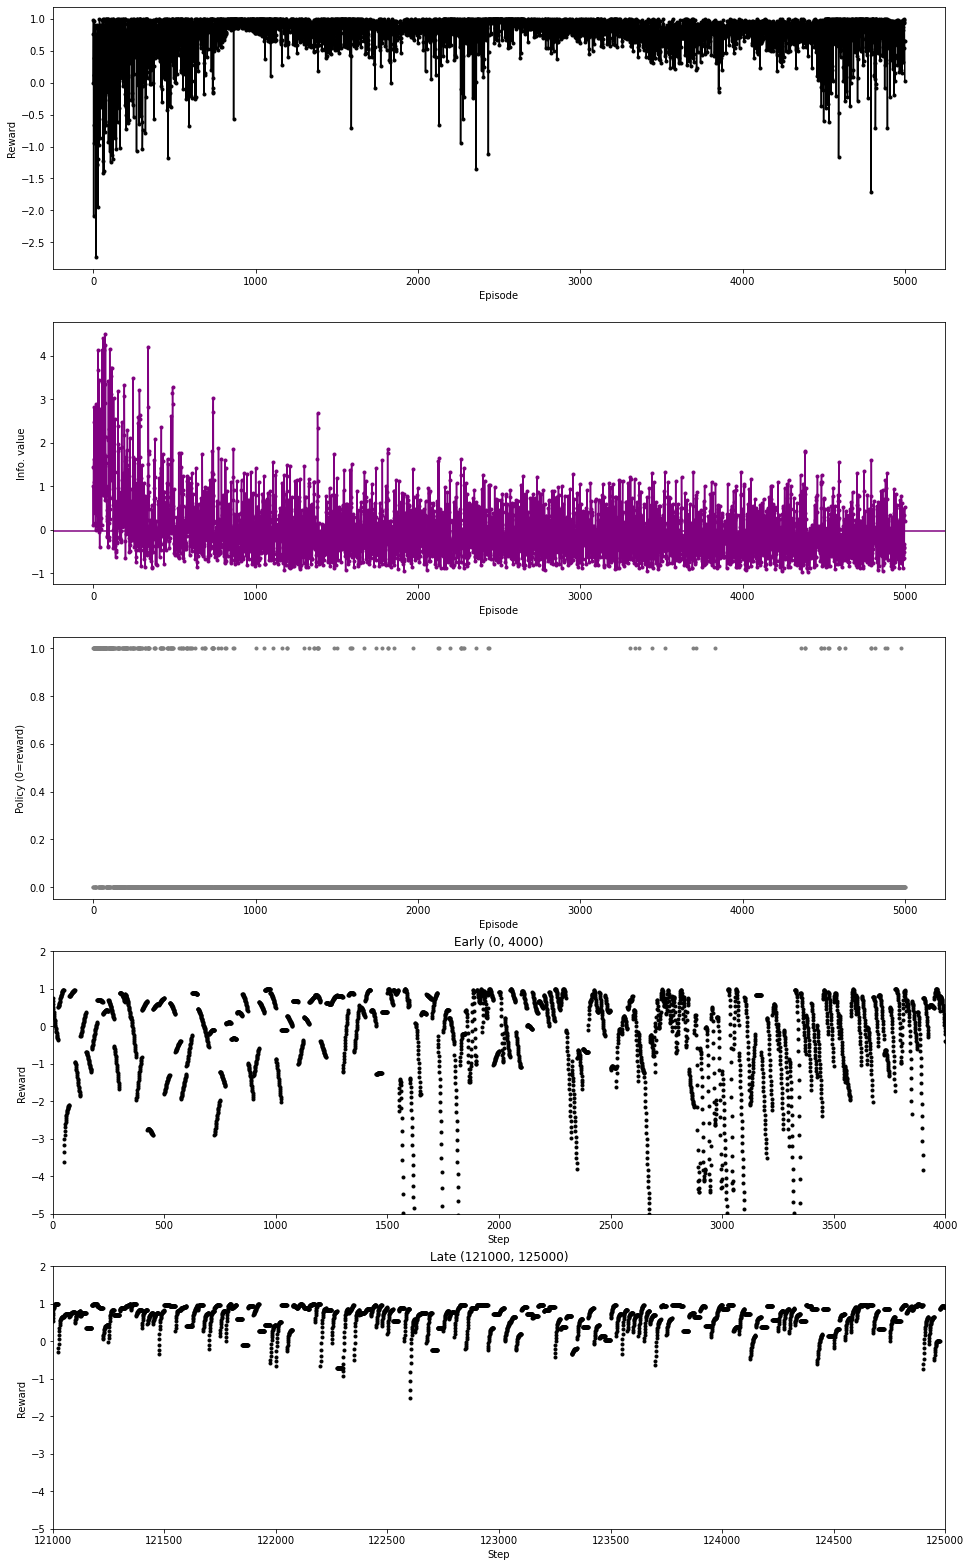

In [31]:
agent = "agent_0"
i = env.possible_agents.index(agent)

# ---
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(16, 28))

# Best per ep
times = np.arange(0, len(total_rewards))
ax1.plot(times, np.vstack(total_rewards)[:,i], '.-', color="black")
ax1.set_ylabel("Reward")
ax1.set_xlabel("Episode")

times = np.arange(0, len(total_intrinsics))
ax2.plot(times, np.vstack(total_intrinsics)[:,i], '.-', color="purple")
ax2.axhline(np.vstack(total_intrinsics)[:,i].mean(), color="purple")
ax2.set_ylabel("Info. value")
ax2.set_xlabel("Episode")

# Eq policy - WSLS
eta = 0.5
meta = []
rewards = np.vstack(total_rewards)[:,i]
infovals = np.vstack(total_intrinsics)[:,i]
meta = (infovals - eta) > rewards
print(rewards)
times = np.arange(0, len(meta))
ax3.plot(times, meta, '.', color="grey", label="WSLS")
ax3.set_ylabel("Policy (0=reward)")
ax3.set_xlabel("Episode")

# All steps
times = np.arange(0, np.asarray([r[agent] for r in episode_rewards]).size)
ax4.plot(times, np.asarray([r[agent] for r in episode_rewards]), '.', color="black", label="reward")
ax4.set_ylabel("Reward")
ax4.set_xlabel("Step")
ax4.set_xlim(0, 4000)
ax4.set_ylim(-5, 2)
ax4.set_title("Early (0, 4000)")

start = times.size - 4000
stop = times.size
ax5.plot(times, np.asarray([r[agent] for r in episode_rewards]), '.', color="black", label="reward")
ax5.set_ylabel("Reward")
ax5.set_xlabel("Step")
ax5.set_xlim(start, stop)
ax5.set_ylim(-5, 2)
ax5.set_title(f"Late ({start}, {stop})")